In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.primitives import StatevectorSampler,StatevectorEstimator
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile
import qiskit.quantum_info as qi
from qiskit.quantum_info.operators import SparsePauliOp
from itertools import product
from scipy.linalg import expm
import numpy as np
import matplotlib.pyplot as plt

**WARNING**

The IBM platform to monitor jobs on real devices is migrating. We will use the old version for this project, available at this link : https://quantum.ibm.com

## The HHL algorithm 

We want to implement the quantum circuit that allows us to solve linear systems of equations. We want to solve $Ax=b$ with full rank the matrix $A \in \mathbb{C}^{ 2^n\times 2^n}$ and a vector $b \in \mathbb{C}^{ 2^n}$.

For that, we encode $b$ in a state $|b \rangle$ such that $|b\rangle = \sum_{i=0}^{2^n-1} b_i |i\rangle$. Here, the $b_i$ are the components of $b$ and $|i\rangle$ is the state of the computational basis given by the binary decomposition of $i$. 

The solution x is then given by $ |x\rangle = cA^{-1}|b\rangle, \quad c^{-1} =\|A^{-1}|b\rangle\|$. 

We have shown in the handout that if $(|u_i\rangle)_{i=0, \dots,2^n-1}$ is an eigenbasis of $A$ associated to the eigenvalues $\lambda_i$ then we can rewrite $ |b\rangle = \sum_{i=0}^{2^n-1} \beta_i |u_i\rangle $ and the state $|x\rangle$ is $|x\rangle = c \sum_{i=0}^{2^n-1} \frac{\beta_i}{\lambda_i} |u_i\rangle$.

The circuit we want to implement is the following: 

<img src="./circuit.png" alt="drawing" width="800">

To have an easy implementation of the algorithm, we impose several constraints on $A$: 

- A is Hermitian.
- The eigenvalues of $A$ are powers of 2. 

We give below a function that allows you to sample a matrix $A$ that verifies those constraints. 

In [2]:
def sample_A(n,i):
    """
    Sample a random n-qubit Hermitian matrix A with eigenvalues being powers of 2 and at most 2^{i-1}.
    """
    G = np.triu(np.random.rand(2**n, 2**n)) + 1j * np.triu(np.random.rand(2**n, 2**n))
    H = G + G.T.conj()
    np.fill_diagonal(H, np.random.rand(2**n))
    _, v = np.linalg.eigh(H)
    return v @ np.diag(np.random.choice([2**j for j in range(i)], 2**n)) @ v.T.conj()  # random

### The QPE 

Let's start with the quantum phase estimation part. 

The detailed circuit is the following: 

<img src="./qpe.png" alt="drawing" width="600">


To implement the inverse QPE, we will need the inverse gates. Thus, we will construct both every time.


#### Hadamard Layer 

We start by constructing a layer of Hadamard gates. Complete the following cell. 

In [3]:
def Hadamard_layer(m):
    """
    Returns a quantum circuit that applies the Hadamard gate to each of the m qubits in the circuit.
    """
    qc = QuantumCircuit(m, name="$H^{\otimes m}$")
    for i in range(m):
        qc.h(i)
    return qc

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/var/folders/0r/nnn8yqwd549bhsr3jqz9kqyh0000gn/T/ipykernel_33544/147129048.py:5: SyntaxWarning: invalid escape sequence '\o'
  qc = QuantumCircuit(m, name="$H^{\otimes m}$")


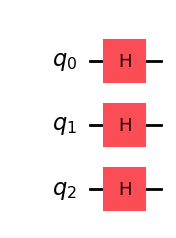

In [4]:
qc = Hadamard_layer(3)
qc.draw('mpl')

Let's check that our function is correct by applying it to the state |0⟩⊗3 and checking that the resulting state is the uniform superposition over all 3-qubit strings.

To draw the output state, `qiskit` can require the package `pylatexenc`. To install it, you can use `pip install pylatexenc`.

In [5]:
# run the circuit with initial state |0>^{\otimes 3} 
output = qi.Statevector.from_instruction(qc)
uniform = np.ones(2**3)/np.sqrt(2**3)

display(output.draw('latex'))

print("The output state is uniform :", output.equiv(uniform))

<IPython.core.display.Latex object>

The output state is uniform : True


The Hadamard gate is its own inverse, since $HH^\dagger = H^2 = I$. 

#### Controlled Unitary

We need now to implement the controlled version of the gate $U^{2^i} $ for $0 \leq i < m$. Complete the following cell. 

Hint : Let's recall that $U = e^{i 2\pi\frac{A}{2^m}}$. The exponential of a matrix can be computed using `expm` from the `sympy` library. Arbitrary unitary can be added to the circuit with `UnitaryGate` from the qiskit library. 

In [6]:
plt.rc('text', usetex=False)  
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')  

def controlled_Us(A, n, m):
    """
    Returns a quantum circuit that applies the m controlled-U^{2^i} gates 
    U is a 2^n x 2^n matrix, and m is the number of control qubits.
    U is U = e^{i 2 pi A/2^m} where A is a Hermitian matrix.
    """
    qc = QuantumCircuit(n + m, name="cU")
    U_base = expm(1j * 2 * np.pi * A / (2**m))
    U_base = qi.Operator(U_base)
    U_base = UnitaryGate(U_base, label="U")
    target_qubits = list(range(m, m+n))
    for i in range(m):
        U_power = expm(1j * 2 * np.pi * A * (2**i)/ (2**m))
        U_power = qi.Operator(U_power)
        U_power_gate = UnitaryGate(U_power, label=f"$U^{{2^{i}}}$")
        qc.append(U_power_gate.control(), [i] + target_qubits)
    return qc

We also need the inverse operation. For that, we need to add the **inverse** of the controlled $U^{2^i} $ in **reverse** order. 

Think about what is the inverse of $U$.

In [7]:
def inverse_controlled_Us(A, n, m):
    """
    Returns a quantum circuit that applies the m controlled-U^{2^i} gates 
    U is a 2^n x 2^n matrix, and m is the number of control qubits.
    U is U = e^{i 2 pi A/2^m} where A is a Hermitian matrix.
    """
    qc = QuantumCircuit(n + m, name="c$U^\dagger$")
    U_base = expm(-1j * 2 * np.pi * A / (2**m))
    U_base = qi.Operator(U_base)
    U_base = UnitaryGate(U_base, label="c$U^\dagger$")
    target_qubits = list(range(m, m+n))
    for i in range(m - 1, -1, -1):
        U_power = expm(-1j * 2 * np.pi * A * (2**i)/ (2**m))
        U_power = qi.Operator(U_power)
        U_power_gate = UnitaryGate(U_power, label=f"$(U^{{\\dagger}})^{{2^{i}}}$")
        qc.append(U_power_gate.control(), [i] + target_qubits)
    return qc

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/var/folders/0r/nnn8yqwd549bhsr3jqz9kqyh0000gn/T/ipykernel_33544/3016337406.py:7: SyntaxWarning: invalid escape sequence '\d'
  qc = QuantumCircuit(n + m, name="c$U^\dagger$")
/var/folders/0r/nnn8yqwd549bhsr3jqz9kqyh0000gn/T/ipykernel_33544/3016337406.py:10: SyntaxWarning: invalid escape sequence '\d'
  U_base = UnitaryGate(U_base, label="c$U^\dagger$")


Let's draw the circuit.

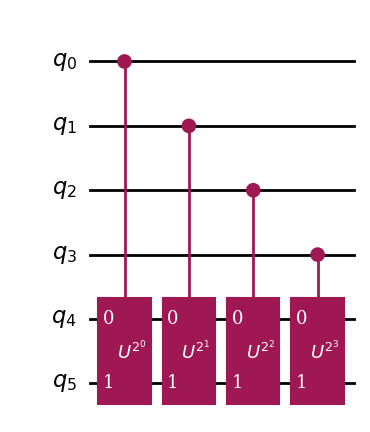

In [8]:
# Example usage
n = 2 #nb of qubits for A 
m = 4 #nb of memory qubits
A = sample_A(n, m)
qc = controlled_Us(A, n, m)
display(qc.draw('mpl'))

And check that applying our two functions one after the other gives the identity.

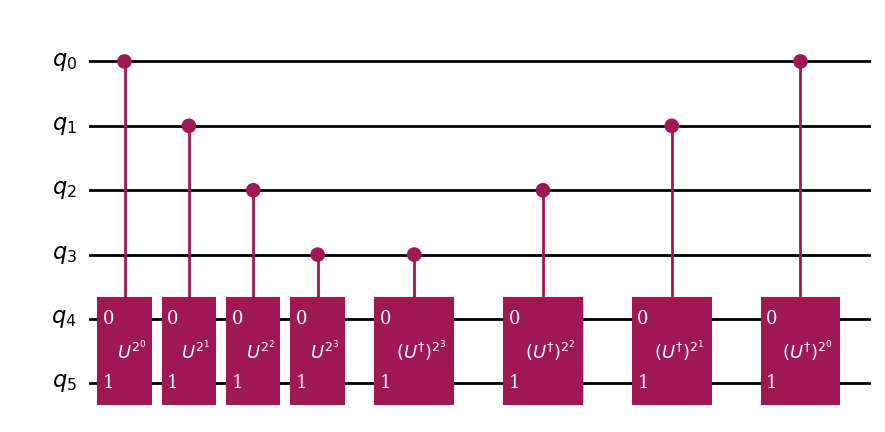

The circuit is equivalent to the Identity: True


In [9]:
qc = QuantumCircuit(m+n)

qc.append(controlled_Us(A, n, m), range(m+n))
qc.append(inverse_controlled_Us(A,n,m), range(m+n))
display(qc.decompose().draw('mpl'))

# Convert the circuit to a unitary matrix
U_circuit = qi.Operator(qc)

print("The circuit is equivalent to the Identity:" , np.allclose(U_circuit.data, np.eye(2**(m+n))))


#### QFT

To finish the QPE, we need to implement the QFT. Do not use `qiskit QFT` other than to check your result (the qubit ordering is different). 

In [10]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n)


def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


def QFT(m):
    """
    Returns a quantum circuit implementing the Quantum Fourier Transform on m qubits
    """
    qc = QuantumCircuit(m, name=r"$QFT$")
    qft_rotations(qc, m)
    swap_registers(qc, m)
    return qc

And the inverse QFT.

In [11]:
def inv_QFT(m):
    """
    Returns a quantum circuit implementing the inverse Quantum Fourier Transform on m qubits
    """
    qc = QuantumCircuit(m, name=r"$QFT^\dagger$")
    qft_circ = QFT(m)
    invqft_circ = qft_circ.inverse()
    qc.append(invqft_circ, qc.qubits[:m])
    return qc
    ## If we want to see the decomposition in single gates
    # return qc.decompose()

Let's draw the circuit.

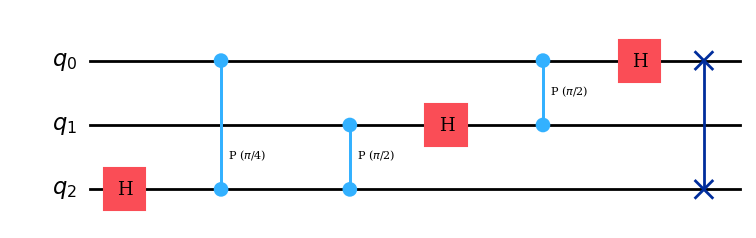

In [12]:
# Example usage
m = 3
qc = QFT(m)
qc.draw(output="mpl")

Let's check that $QFT|k\rangle =\frac{1}{\sqrt{2^m}} \sum_{j=0}^{2^m-1} e^{i2\pi \frac{kj}{2^m} }|j\rangle$. You can also check yourself that $QFT\, QFT^\dagger= I $

In [13]:
# Choose any state in the computational basis. We chose |k> = |5 > for the example.
k = 5
state = qi.Statevector.from_int(k,2**m)
qc = QuantumCircuit(m)
qc.initialize(state, range(m))
qc.append(QFT(m), range(m))
output = qi.Statevector.from_instruction(qc)

expected = np.exp(2j * np.pi * k *  np.arange(2**m) /2**m) / np.sqrt(2**m)

print("The output state is the QFT of the input state:", output.equiv(expected))

The output state is the QFT of the input state: True


Let's construct our QPE circuit at last. We do not add the ancilla qubit for now. 

In [14]:
def QPE(A, n, m):
    """
    Returns a quantum circuit that implements the Quantum Phase Estimation algorithm
    A is a 2^n x 2^n matrix, and m is the number of memory qubits.
    """
    qc = QuantumCircuit(n + m)
    qc.append(Hadamard_layer(m), range(m))
    qc.append(controlled_Us(A, n, m), range(m+n))
    qc.append(inv_QFT(m), range(m))
              
    return qc



We will now test the QPE algorithm on a simple example. Let's consider the matrix $A = diag(1,2,4,8)$. The eigenvalues are $2^0,2^1,2^2,2^3$ associated to the eigenvectors $|00\rangle = |0\rangle, |01\rangle=|1\rangle,|10\rangle = |2\rangle,|11\rangle = |3\rangle$.
If we choose $|b\rangle = |i\rangle$ one of the eigenvectors, then we expect the output to be $|2^i\rangle \otimes |i\rangle $.

In the next cell, we choose $|b\rangle = |1 \rangle$, but you can change it to the one you want.


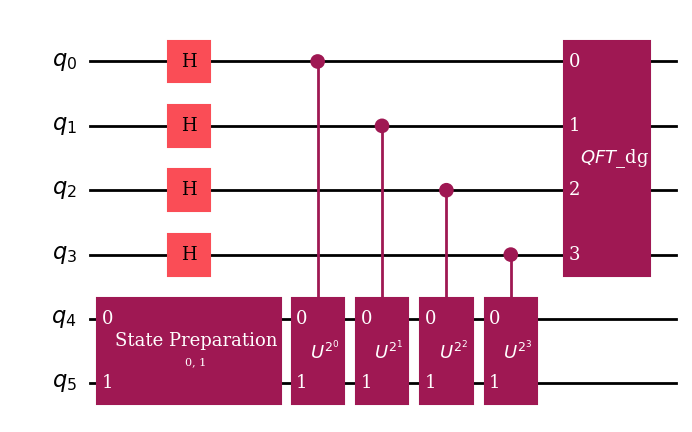

In [15]:
n = 2 #nb of qubits for A 
m = 4 #nb of memory qubits
A = np.diag([1,2,4,8])

qpe_circuit = QuantumCircuit(n + m)
# Initialize the state |b> in the computational basis; here we choose |b> = |1> = | 01>
qpe_circuit.prepare_state("01", range(m,n+m))
qpe_circuit = qpe_circuit.compose(QPE(A, n, m).decompose())
qpe_circuit.draw(output="mpl",fold=-1)


**Warning**: Since qiskit changes the order of the qubits, we should instead observe $|i\rangle \otimes |2^i\rangle $. 

With our example, we should observe $|1\rangle \otimes |2\rangle = |01\rangle \otimes |0010\rangle $

In [16]:
output = qi.Statevector.from_instruction(qpe_circuit)
display(output.draw('latex'))

<IPython.core.display.Latex object>

### The controlled rotation 

The central part of the algorithm is the control rotation that realizes the transformation $ R(|0\rangle \otimes |\lambda\rangle) = \left(\sqrt{1-\frac{1}{\lambda^2}}|0\rangle + \frac{1}{\lambda}|1\rangle\right) \otimes |\lambda\rangle $.

#### But how to implement this operation ?

First, note that since the eigenvalues are powers of 2, the only eigenvalue that has a $1$ at the $i$-th position in its binary decomposition is $2^i$. We also assume that $\max_i (\lambda_i) \leq 2^{m-1}$. Thus, we can use the qubit $i$ to know if the memory register is in the state $|2^i\rangle $ or not. We will use $m$ controlled $R_y(\theta_i)$ gates, one per possible eigenvalue, to implement $R$. 

Remember that the $R_y$ gate is the unitary given by $R_y(\theta) = \left( \begin{array}{cc} cos(\theta/2) & -sin(\theta/2)\\ sin(\theta/2) & cos(\theta/2) \end{array}\right)$. 

Each controlled rotation will act on the first ancilla qubit and be controlled by the $i$-th qubit of the memory register, we denote them $c_iR_y(\theta_i)$.

Thus, we have the decomposition $ R = c_1R_y(\theta_1) \dots c_m R_y(\theta_m)$.

What value of $\theta_i$ should you choose to obtain $ R(|0\rangle \otimes |2^i \rangle) = \left(\sqrt{1-\frac{1}{2^{2i}}}|0\rangle + \frac{1}{2^i}|1\rangle\right) \otimes |2^i\rangle $ ? 



In the next cell, we choose i = 2 for the test. 

**Warning**: **Be careful with the ordering of the qubits!**

In our handout, the ancilla register comes first, then comes the memory register: $ |0\rangle |2^2 \rangle $ 

In qiskit, the order is reversed: $ |2^2 \rangle |0\rangle$.

In our handout, the binary decomposition is written from left to right, from the most significant bit to the least significant bit : $|4\rangle = |100\rangle$.

In qiskit, the order is reversed. 

So the input state is $|0\rangle_{q_0} |2^2 \rangle_{q_1q_2q_3}  = |1 \rangle_{q_3}|0 \rangle_{q_2}|0 \rangle_{q_1} |0\rangle_{q_0}$

In [17]:
def R(m):
    """
    Returns a quantum circuit that implements the R operator
    R = \prod_{i=1}^m C_i R_y
    where R_y^i is a controlled rotation gate.
    """
    qc = QuantumCircuit(m + 1, name="R")
    for i in range(m):
        theta_i = 2 * np.arcsin(1 / (2**i))
        qc.cry(theta_i, i+1, 0)
    return qc

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/var/folders/0r/nnn8yqwd549bhsr3jqz9kqyh0000gn/T/ipykernel_33544/4201816507.py:2: SyntaxWarning: invalid escape sequence '\p'
  """


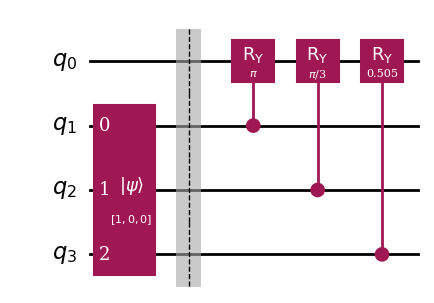

In [18]:
qc_R = QuantumCircuit(4)
qc_R.initialize("100",[1,2,3])  # input state |100> = |4> = |2^2>
qc_R.barrier()
qc_R = qc_R.compose(R(3), range(4))
display(qc_R.draw(output="mpl"))

 For the output state, with qiskit ordering, we should observe $\sqrt{1 - 2^{-2i}}|2^i\rangle |0\rangle + 1/ 2^i  |2^i\rangle |1\rangle$. 

In our case, we should observe $\sqrt{15/16}|2^2\rangle |0\rangle + 1/ 2^2  |2^2 \rangle |1\rangle = \sqrt{15/16}|100\rangle |0\rangle + 1/ 4  |100 \rangle |1\rangle$.

In [19]:
output = qi.Statevector.from_instruction(qc_R)
display(output.draw('latex'))

<IPython.core.display.Latex object>

### Complete circuit

We are ready to implement the complete circuit.

Complete the next cell with the HHL circuit **without** the last measurement. 

In [20]:
def inverse_QPE(A, n, m):
    """
    Returns a quantum circuit that implements the inverse Quantum Phase Estimation algorithm
    A is a 2^n x 2^n matrix, and m is the number of memory qubits.
    """
    qc = QuantumCircuit(n + m)
    qc.append(QFT(m), range(m))
    qc.append(inverse_controlled_Us(A, n, m), range(m+n))
    qc.append(Hadamard_layer(m), range(m))
              
    return qc

def hhl_circuit(A, b, n, m):
    """
    Returns a quantum circuit that implements the HHL algorithm
    A is a 2^n x 2^n Hermitian matrix, and b is a vector of size 2^n.
    The circuit uses 1 ancilla qubits and m memory qubit and n qubits for b.
    """
   
    qc = QuantumCircuit(1+ n + m, name="Complete circuit")
    qc.initialize(b, range(m + 1, m + n + 1))
    qc = qc.compose(QPE(A, n, m), range(1, n+m+1))
    qc = qc.compose(R(m))
    qc = qc.compose(inverse_QPE(A, n, m), range(1, n+m+1))
    return qc

Let's test it with a random $A$. If you need to debug your code, you might prefer reusing the previous diagonal $A$. 

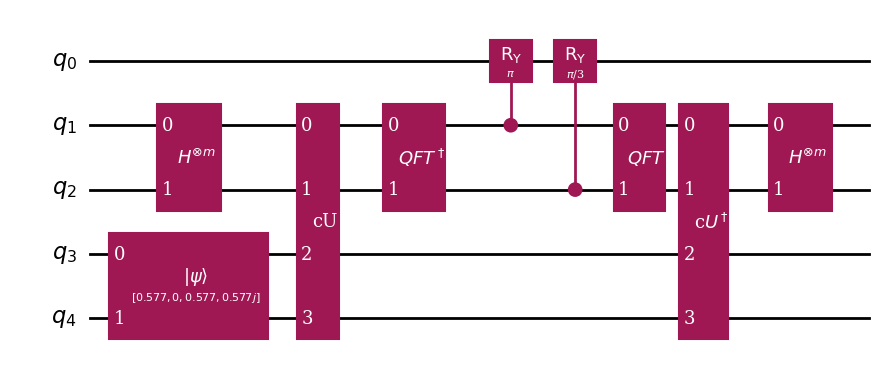

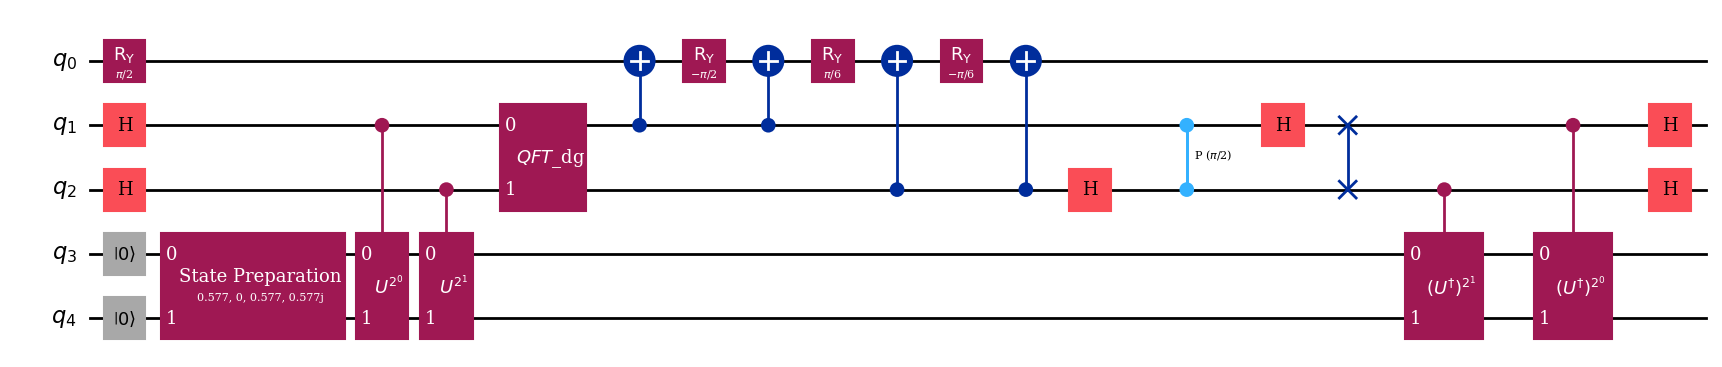

In [21]:
np.random.seed(0)
n = 2
m = 2
A = sample_A(n,m)
# A = np.diag([1,2,4,8])
b = np.array([1,0, 1, 1j]) 
b = b / np.linalg.norm(b)


final_circuit = hhl_circuit(A, b,n, m)
display(final_circuit.draw(output="mpl",fold=-1))
display(final_circuit.decompose().draw(output="mpl", fold=-1))

#### Final state

We should observe that the memory qubits are all 0 as predicted.

In [22]:
output = qi.Statevector.from_instruction(final_circuit)
display(output.draw('latex'))

<IPython.core.display.Latex object>

The final state of the circuit is $ |0 \rangle |0^{\otimes m} \rangle |y\rangle + |1\rangle |0^{\otimes m} \rangle|x\rangle $ where $|x\rangle $ is the solution of the system and $|y\rangle$ is not. 

Let extract $|x \rangle$ from the output state to verify that it's a solution to our system of equations. 

**Warning**: since the order of the qubits is reversed, what you really observed in the output state is $|y\rangle|0^{\otimes m} \rangle |0 \rangle+ |x\rangle |0^{\otimes m} \rangle |1\rangle $!

*Hint*: $$|a\rangle|0\rangle|0\rangle =  \left( \begin{array}{c} a_1 \\ a_2 \end{array}\right) \otimes \left( \begin{array}{c} 1 \\ 0\\ 0\\0  \end{array}\right)  = \left( \begin{array}{c} a_1 \\ 0\\ 0\\0 \\ a_2 \\ 0\\ 0\\0  \end{array}\right) $$

In [23]:
output_state = output.data
# print("The output state is:", output_state)
x = qi.Statevector(output_state[[i for i in range(1, 2**(n + m + 1), 2**(m+1))]]/np.linalg.norm(output_state[[i for i in range(1, 2**(n + m + 1), 2**(m+1))]]))
# print(x)

expected_solution = np.linalg.solve(A, b)
expected_solution = expected_solution / np.linalg.norm(expected_solution)
# print("expected_solution:", expected_solution)
# print("expected_solution:", expected_solution.shape)
print("The output state is the expected solution:", x.equiv(expected_solution))


The output state is the expected solution: True


If we measure the ancilla qubit, what is the probability to obtain "1"?

In [24]:
p = (np.linalg.norm(output.data[[i for i in range(1, 2**(n + m + 1), 2**(m+1))]]))**2

print("The probability of success is: ", p)

The probability of success is:  0.9446615615655191


Let's simulate the circuit to verify that we obtain the same value.
Add the measurement on the ancilla qubit to your circuit.

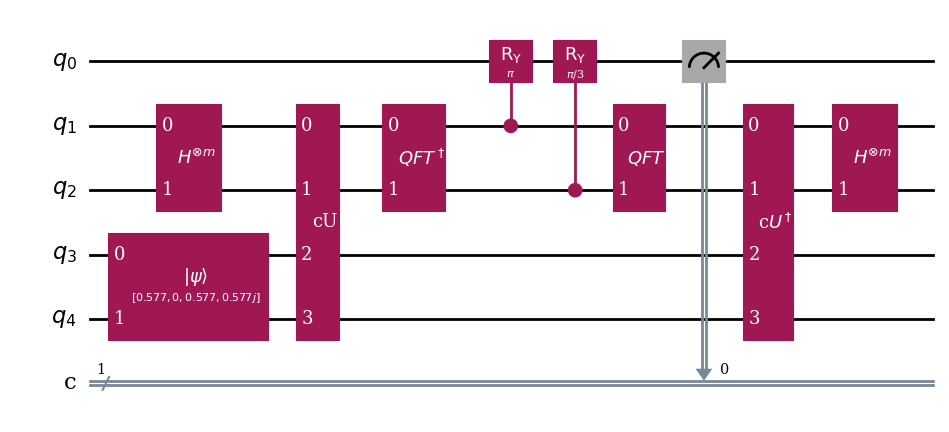

In [25]:
circuit_with_measurements = QuantumCircuit( n + m + 1, 1)
circuit_with_measurements.compose(final_circuit, inplace=True)
circuit_with_measurements.measure(0,0)
display(circuit_with_measurements.draw(output="mpl",fold=-1))

Set up your simulator using a `StatevectorSampler`.

**Warning**: When you measure all qubits, the result of the measure is in the attribute `data.meas` of the job result. When you measure only a few qubits, the result of the measure is in the attribute `data.c`.

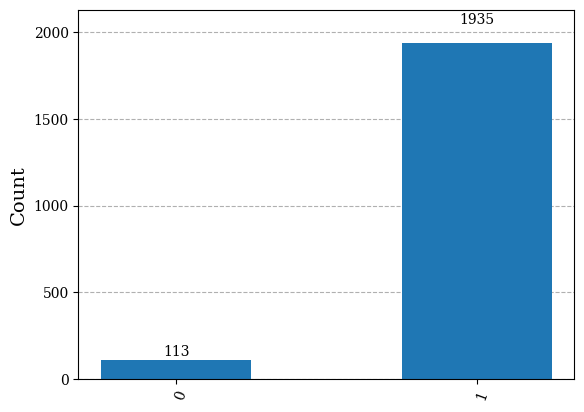

The counts: {'1': 1935, '0': 113}
The probabilities: {'1': 0.94482421875, '0': 0.05517578125}


In [26]:
sim_ideal_prim = StatevectorSampler(seed=42) 
n_shots = 2048
job_ideal = sim_ideal_prim.run([circuit_with_measurements], shots=n_shots)
res_ideal = job_ideal.result()  
counts = res_ideal[0].data.c.get_counts()



display(plot_histogram(counts))
print("The counts:" , counts)
print("The probabilities:" , {key: value/n_shots for key, value in counts.items()})





### Reconstructing $|x\rangle$ 



For this part, we will solve the specific system given in the handout. The eigenvalues of $A$ are only $1$ and $2$.

Start by creating the circuit with the appropriate $A$ and $b$.  Add the measurements for the ancilla qubit and the $|x\rangle$ register. 

Compute also the expected solution and the success probability.

The probability of success is:  0.9249999999999919
The expected solution is: [ 0.81373347 -0.58123819]


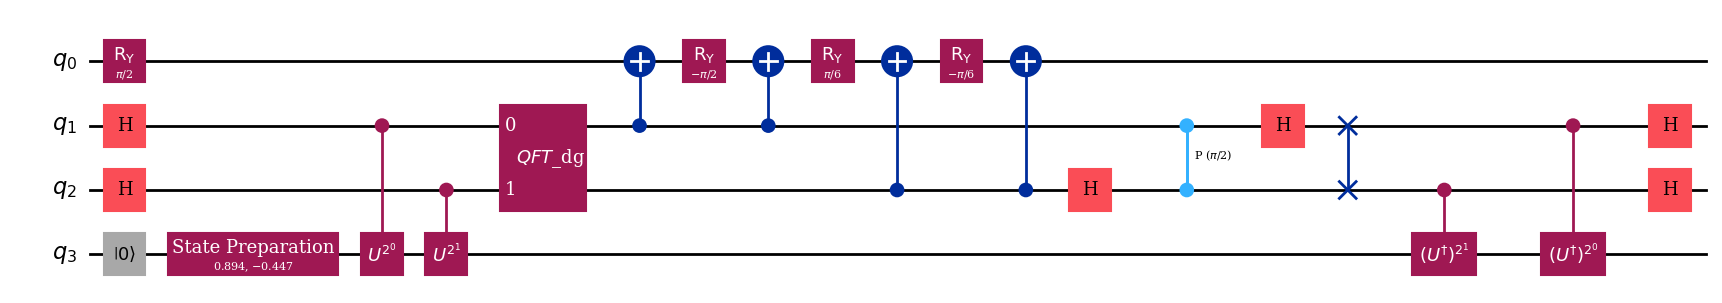

In [27]:
n = 1
m = 2

A = np.matrix([[3, 1], [1, 3]])/2
b = np.array([2/np.sqrt(3), -1/np.sqrt(3)])/np.linalg.norm([2/np.sqrt(3), -1/np.sqrt(3)])

final_circuit =  hhl_circuit(A, b,n, m)

expected_solution = np.linalg.solve(A, b)/np.linalg.norm(np.linalg.solve(A, b))

output = qi.Statevector.from_instruction(final_circuit)
p = (np.linalg.norm(output.data[[i for i in range(1, 2**(n + m + 1), 2**(m+1))]]))**2


print("The probability of success is: ",  p) 
print("The expected solution is:", expected_solution)
display(final_circuit.decompose().draw(output="mpl",fold=-1))




Use a `StatevectorSampler` to measure the first and last qubit. 

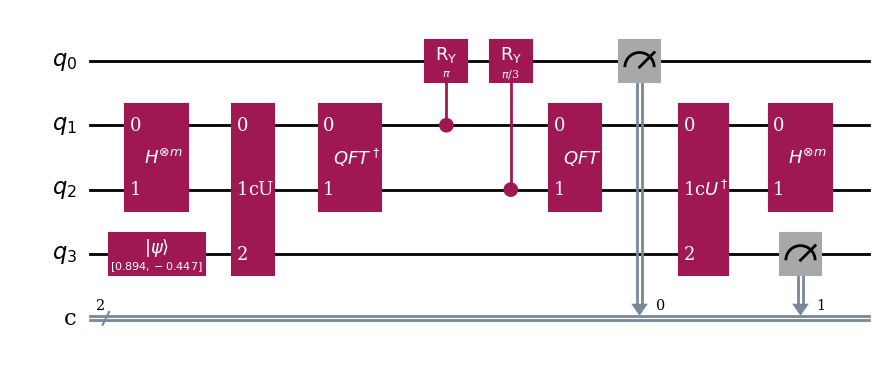

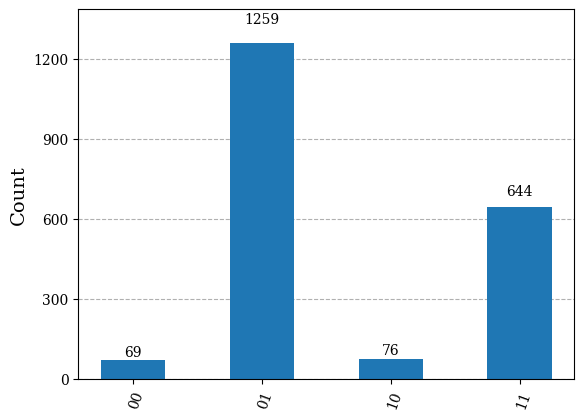

The counts: {'11': 644, '01': 1259, '10': 76, '00': 69}
The probabilities: {'11': 0.314453125, '01': 0.61474609375, '10': 0.037109375, '00': 0.03369140625}


In [28]:
final_circuit_with_measurements = QuantumCircuit( n + m + 1, 2)
final_circuit_with_measurements.compose(final_circuit, inplace=True)
final_circuit_with_measurements.measure(0,0)
final_circuit_with_measurements.measure(n+m,1)
display(final_circuit_with_measurements.draw(output="mpl",fold=-1))

sim_ideal_prim = StatevectorSampler(seed=42) 
n_shots = 2048
job_ideal = sim_ideal_prim.run([final_circuit_with_measurements], shots=n_shots)
res_ideal = job_ideal.result()  
counts = res_ideal[0].data.c.get_counts()


display(plot_histogram(counts))
print("The counts:" , counts)
print("The probabilities:" , {key: value/n_shots for key, value in counts.items()})

Try reconstructing $|x\rangle$ from the output of the measurement. What is missing to completely determine $|x\rangle$?

In [29]:
## We need to keep only counts where q0 = 1, then take 
## the frequency as the probability of the state and 
## take the square root to get an amplitde.

frequency_01 = counts.get('01',0)/n_shots
frequency_11 = counts.get('11',0)/n_shots

print("The probability of success for |01> is: ", frequency_01)
print("The probability of success for |11> is: ", frequency_11)

x_simulator = np.sqrt(frequency_01) * np.array([1,0]) + np.sqrt(frequency_11) * np.array([0,1])
x_simulator /= np.linalg.norm(x_simulator)

print("The output state reconstructed is:", x_simulator)
print("The expected solution is:", expected_solution)

print("The output state is the expected solution:", np.allclose(x_simulator, expected_solution))
## What is missing to completly determine |x> :
print("We can not reconstruct exactly the solution since we don't have access to the local phase.\nThis is due to the fact that we are performing measurements, killing quantum coherence.")




The probability of success for |01> is:  0.61474609375
The probability of success for |11> is:  0.314453125
The output state reconstructed is: [0.81337997 0.58173278]
The expected solution is: [ 0.81373347 -0.58123819]
The output state is the expected solution: False
We can not reconstruct exactly the solution since we don't have access to the local phase.
This is due to the fact that we are performing measurements, killing quantum coherence.


Now let see what happens on a real device. 

First, make sure `qiskit_ibm_runtime` is installed. If not, run `pip install qiskit-ibm-runtime` in your Python environment. Then, set up to use IBM Quantum Platform according to the [guide](https://docs.quantum.ibm.com/guides/setup-channel#set-up-to-use-ibm-quantum-platform).

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

Let's choose a backend. Below, we are using the least busy one, but you can pre-set it if you want.

In [31]:
backend = service.least_busy(operational=True)
print(backend)

<IBMBackend('ibm_brisbane')>


Now, we want to send the circuits to a QPU. However, before this, we have to adapt them to the architecture of the chosen computer, as it might have a specific topology and a limited number of implemented basis gates. Transpile your circuit to adapt it to the backend architecture. 


In [32]:
backend.configuration().basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

Depth of circuit after transpiling: 107


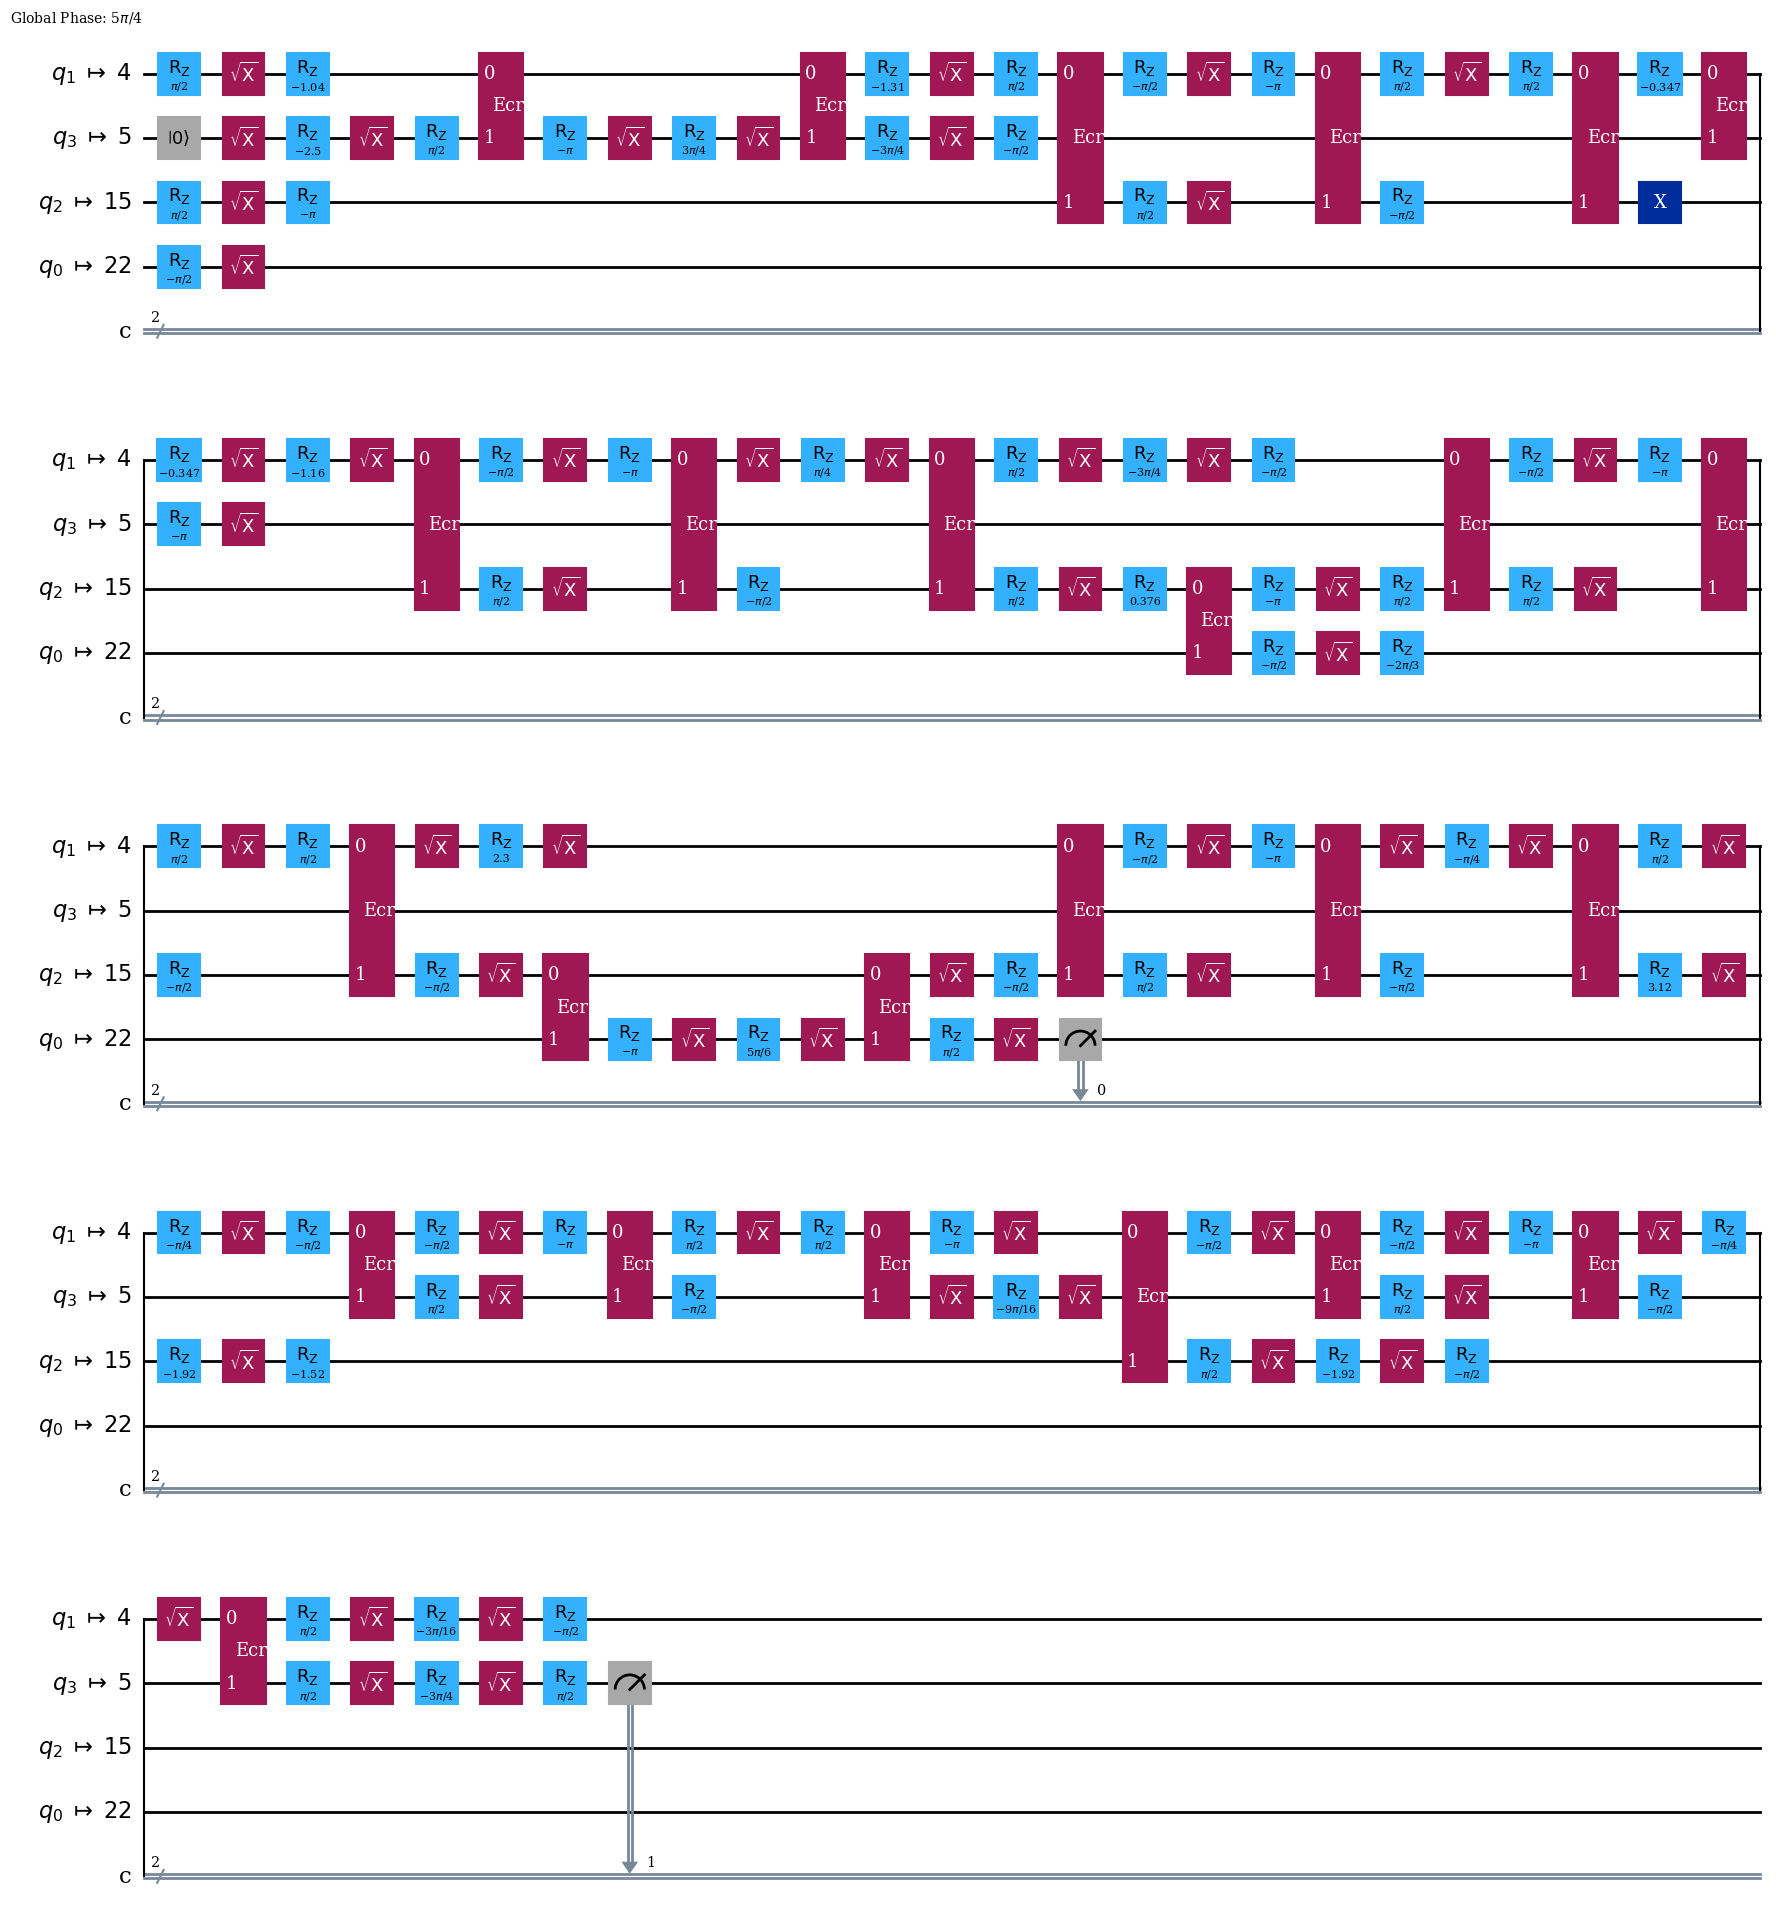

In [33]:
transpiled_qc  = transpile(final_circuit_with_measurements, backend=backend, optimization_level=3)
print(f'Depth of circuit after transpiling: {transpiled_qc.depth()}')
transpiled_qc.draw(output="mpl",idle_wires=False)

Now, we instantiate the [`Sampler`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2) interface which allows us to use the backend for measurement.

In [34]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)

n_shots = 2048

job = sampler.run([transpiled_qc], shots=n_shots)
print(f">>> Job ID: {job.job_id()}")


>>> Job ID: d0tbr0r4mb60008xdh8g


In [35]:
res = job.result()
pub_result = res[0]
print(pub_result.data.c.get_counts())
counts =  pub_result.data.c.get_counts()

print("The counts:" , counts)
print("The probabilities:" , {key: value/n_shots for key, value in counts.items()})

{'00': 490, '11': 630, '01': 505, '10': 423}
The counts: {'00': 490, '11': 630, '01': 505, '10': 423}
The probabilities: {'00': 0.2392578125, '11': 0.3076171875, '01': 0.24658203125, '10': 0.20654296875}


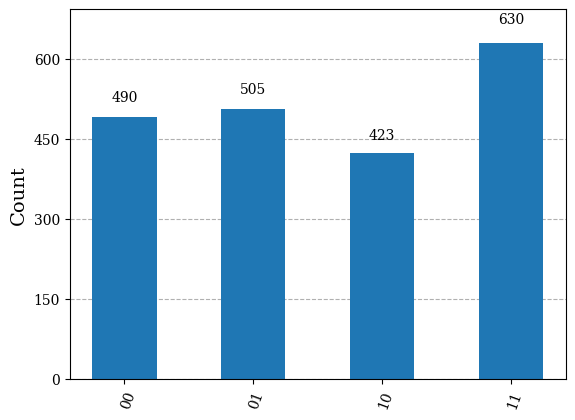

In [36]:
plot_histogram(counts)

Reconstruct $|x\rangle$. Compare the result to the one obtained with the simulator. 

In [37]:
frequency_01 = counts.get('01',0)/n_shots
frequency_11 = counts.get('11',0)/n_shots

print("The probability of success for |01> is: ", frequency_01)
print("The probability of success for |11> is: ", frequency_11)




x_real = np.sqrt(frequency_01) * np.array([1,0]) + np.sqrt(frequency_11) * np.array([0,1])
x_real /= np.linalg.norm(x_real)
print("The output state reconstructed is:", x_real)
print("The expected solution is:", expected_solution)
print("The output state is the expected solution:", np.allclose(x_real, expected_solution))


print("Error between the simulated solution and the real device one", np.linalg.norm(x_real - x_simulator))

The probability of success for |01> is:  0.24658203125
The probability of success for |11> is:  0.3076171875
The output state reconstructed is: [0.66703367 0.74502757]
The expected solution is: [ 0.81373347 -0.58123819]
The output state is the expected solution: False
Error between the simulated solution and the real device one 0.2192770490987166


### Bonus

With a real quantum device, we don't have direct access to the state. We can only gain information through measurement. 


Start by creating the circuit with the new $A$ and $b$ without the ancilla measurement. Compute also the expected solution and the probability of success. 

The probability of success is:  0.9583333333333289
The expected solution is: [ 0.72231512-0.08025724j -0.08025724+0.6821865j ]


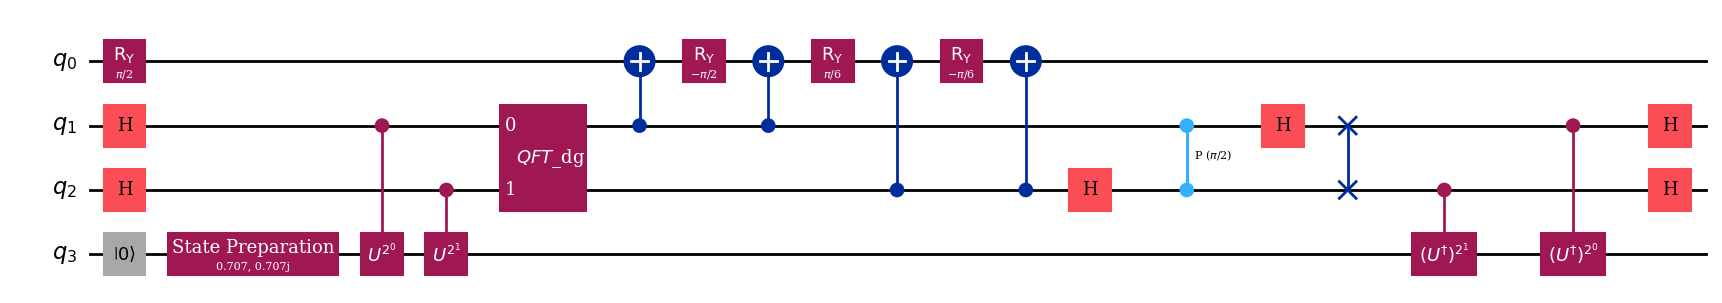

In [38]:
n = 1
m = 2

A = np.matrix([[13, 2 + 4*1j], [2 - 4*1j, 14]])/9
b = np.array([1, 1j])/np.linalg.norm([1, 1j])


final_circuit = hhl_circuit(A, b,n, m)



output = qi.Statevector.from_instruction(final_circuit)
p = (np.linalg.norm(output.data[[i for i in range(1, 2**(n + m + 1), 2**(m+1))]]))**2

print("The probability of success is: ", p)

expected_solution = np.linalg.solve(A, b)/np.linalg.norm(np.linalg.solve(A, b))


print("The expected solution is:", expected_solution)
display(final_circuit.decompose().draw(output="mpl",fold=-1))

Let's create the 4 observables $\sigma \in \{I,X,Y,Z\}$ using `SparsePauliOp`. 

In [39]:

X = SparsePauliOp("X", coeffs=[1.0])
Z = SparsePauliOp("Z", coeffs=[1.0])
Y = SparsePauliOp("Y", coeffs=[1.0])
I = SparsePauliOp("I", coeffs=[1.0]) 

To do the measure on the real device, we need to define the observables for the full circuit, so for the 4 qubits. 

We want to measure the observables only when the result of the measurement on the ancilla qubit is 1.  Thus, the observable for the ancilla qubit will be $P_1 = |1\rangle \langle 1|$. We are not interested in the 2 memory qubits since they are in the state $|0\rangle^{\otimes 2}$, so the final observables will be $P_1 \otimes I \otimes I \otimes \sigma$ instead of just $\sigma$. 
Adapt your previous operators and store them in the list `observables`. You can use the `expand()` method of the operators.


In [40]:
from qiskit.quantum_info import Operator
P1 = (I - Z) / 2
print(Operator(P1).data)
II = I.tensor(I)
print(Operator(II).data)
observable_i = I.tensor(II.tensor(P1))
observable_x = X.tensor(II.tensor(P1))
observable_y = Y.tensor(II.tensor(P1))
observable_z = Z.tensor(II.tensor(P1))
print(Operator(I.tensor(P1)).data)
observables = [observable_i, observable_x, observable_y, observable_z]

for i, obs in enumerate(observables):
    print(f"Observable {i} (σ = {['I', 'X', 'Y', 'Z'][i]}):", obs)

output = qi.Statevector.from_instruction(final_circuit)
display(output.draw('latex'))

[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Observable 0 (σ = I): SparsePauliOp(['IIII', 'IIIZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j])
Observable 1 (σ = X): SparsePauliOp(['XIII', 'XIIZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j])
Observable 2 (σ = Y): SparsePauliOp(['YIII', 'YIIZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j])
Observable 3 (σ = Z): SparsePauliOp(['ZIII', 'ZIIZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j])


<IPython.core.display.Latex object>

#### Simulator 

We start by running our circuit on the simulator.

Set up your simulator using a [`StatevectorEstimator`](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorEstimator) since this time we are measuring observables. 

The result of the measure is in the attribute `data.evs` of the job result (for expectation values). It's a list containing the expectation values $\langle P_1 \otimes I_2 \otimes I_2 \otimes \sigma\rangle$ for $\sigma \in \{I,X,Y,Z\}$.


In [41]:
# import numpy as np
# from qiskit.quantum_info import Statevector, SparsePauliOp
# from qiskit.primitives import StatevectorEstimator
# from qiskit import QuantumCircuit

# # Paramètres
# n = 1
# m = 2
# A = np.matrix([[13, 2 + 4j], [2 - 4j, 14]]) / 9
# b = np.array([1, 1j]) / np.linalg.norm([1, 1j])

# # Créer le circuit HHL
# final_circuit = hhl_circuit(A, b, n, m)

# # Méthode 1 : Probabilité de succès avec Statevector
# output = Statevector.from_instruction(final_circuit)
# p = np.linalg.norm(output.data[[i for i in range(1, 2**(n + m + 1), 2**(m+1))]])
# print("Probability of success (Statevector):", p)

# # Définir P1 pour q_0 (indice 3 dans q_3 q_2 q_1 q_0)
# P1 = SparsePauliOp(["I", "Z"], coeffs=[0.5, -0.5])
# print("P1 num_qubits:", P1.num_qubits)  # Doit être 4

# # Créer les opérateurs σ ⊗ I ⊗ I ⊗ P1 directement sur 4 qubits
# # Ordre : q_3 q_2 q_1 q_0 (indices 0, 2, 1, 3)
# observable_i = P1.expand(SparsePauliOp(["III"], coeffs=[1.0]))  # I on q_3, P1 on q_0
# observable_x = P1.expand(SparsePauliOp(["XII"], coeffs=[1.0]))  # X on q_3, P1 on q_0
# observable_y = P1.expand(SparsePauliOp(["YII"], coeffs=[1.0]))  # Y on q_3, P1 on q_0
# observable_z = P1.expand(SparsePauliOp(["ZII"], coeffs=[1.0]))# Z on q_3, P1 on q_0

# # Vérifier les nombres de qubits
# print("observable_i num_qubits:", observable_i.num_qubits)  # Doit être 4
# print("observable_x num_qubits:", observable_x.num_qubits)  # Doit être 4
# print("observable_y num_qubits:", observable_y.num_qubits)  # Doit être 4
# print("observable_z num_qubits:", observable_z.num_qubits)  # Doit être 4

# # Stocker dans la liste observables
# observables = [observable_i, observable_x, observable_y, observable_z]

# # Configurer l'estimateur
# estimator_perfect = StatevectorEstimator(default_precision=1e-10)

# # Exécuter la simulation
# data_simulated = estimator_perfect.run([(final_circuit, observables)]).result()

# # Afficher les résultats
# print("Measured expectation values:", data_simulated[0].data.evs)
# p_success_estimator = data_simulated[0].data.evs[0]
# print("Probability of success (Estimator):", p_success_estimator)

In [42]:
estimator_perfect = StatevectorEstimator(default_precision=1e-10)

# data_simulated = estimator_perfect.run([final_circuit], observables=[P1], shots=n_shots).result()
# print("The estimated expectation values are: ", data_simulated)

# Exécuter la simulation (pas de shots, tuple [circuit, observables])
data_simulated = estimator_perfect.run([(final_circuit, observables)]).result()

# Afficher les résultats
print("The estimated expectation values are:", data_simulated[0].data.evs)



The estimated expectation values are: [ 0.95833333 -0.21604938  0.93209877  0.05401235]


Reconstruct the matrix $\rho$ from the results of the measurement: 
    $$\rho = \frac{\langle I \rangle I + \langle X \rangle X+\langle Y \rangle Y+\langle Z \rangle Z}{\sqrt{2}}$$

Hint : $Tr (A \otimes B)$ = $Tr(A) Tr(B)$ and verify that $Tr(\rho) =1$

In [43]:
# rho = 
print("The estimated expectation values are:", data_simulated[0].data.evs[0])

coeff_i = data_simulated[0].data.evs[0] / data_simulated[0].data.evs[0]
coeff_x = data_simulated[0].data.evs[1] / data_simulated[0].data.evs[0]
coeff_y = data_simulated[0].data.evs[2] / data_simulated[0].data.evs[0]
coeff_z = data_simulated[0].data.evs[3] / data_simulated[0].data.evs[0]
rho = (coeff_i * I + coeff_x * X + coeff_y * Y + coeff_z * Z) / 2
print("The estimated density matrix is:\n", Operator(rho).data)
print("La trace vaut :",(Operator(rho).data.trace()))




The estimated expectation values are: 0.9583333333953504
The estimated density matrix is:
 [[ 0.52818035+0.j        -0.11272142-0.4863124j]
 [-0.11272142+0.4863124j  0.47181965+0.j       ]]
La trace vaut : (1+0j)


Since $\rho =|x\rangle \langle x|$, compute $|x\rangle$ and check the error with the expected solution. Don't forget about the global phase.
Compare the obtained error with the `default_precision` parameter of the `StatevectorEstimator`. 

In [44]:

## The equations for reconstructing x are :
## |x0|^2 = |rho00|^2
## |x1|^2 = |rho11|^2
## |x0 x1| * exp(i(phi0-phi1)) = |rho10| * exp(-i(phi10)) because rho is hermitian
## |x0 x1| * exp(-i(phi0-phi1)) = |rho10| * exp(i(phi10)) 

rho00 = Operator(rho).data[0][0]
rho01 = Operator(rho).data[0][1]
rho11 = Operator(rho).data[1][1]
rho10 = Operator(rho).data[1][0]

x0 = np.sqrt(rho00)
## Without loss of generality, we can take the phase of rho00 to be 0
x1 = np.sqrt(rho11) * np.exp(1j * np.angle(rho10))

x_reconstructed = np.array([x0, x1])

print("The reconstructed solution is:", x_reconstructed)

print("Error between the simulated solution and the expected one", np.linalg.norm(x_reconstructed - expected_solution))

The reconstructed solution is: [ 0.72676018+0.j         -0.15510126+0.66915114j]
Error between the simulated solution and the expected one 0.11060077149873661


#### Real device

Now we are going to make the observable measurements on a real quantum computer.	



Let's choose a backend. Below, we are using the least busy one, but you can pre-set it if you want.


In [45]:
backend = service.least_busy(operational=True)
print(backend)

<IBMBackend('ibm_brisbane')>


Now, we want to send the circuits to a QPU and measure the observables. However, before this, we have to adapt them to the architecture of the chosen computer, as it might have a specific topology and a limited number of implemented basis gates. Transpile your circuit to adapt it to the backend architecture. 


In [46]:
backend.configuration().basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

Depth of circuit after transpiling: 98


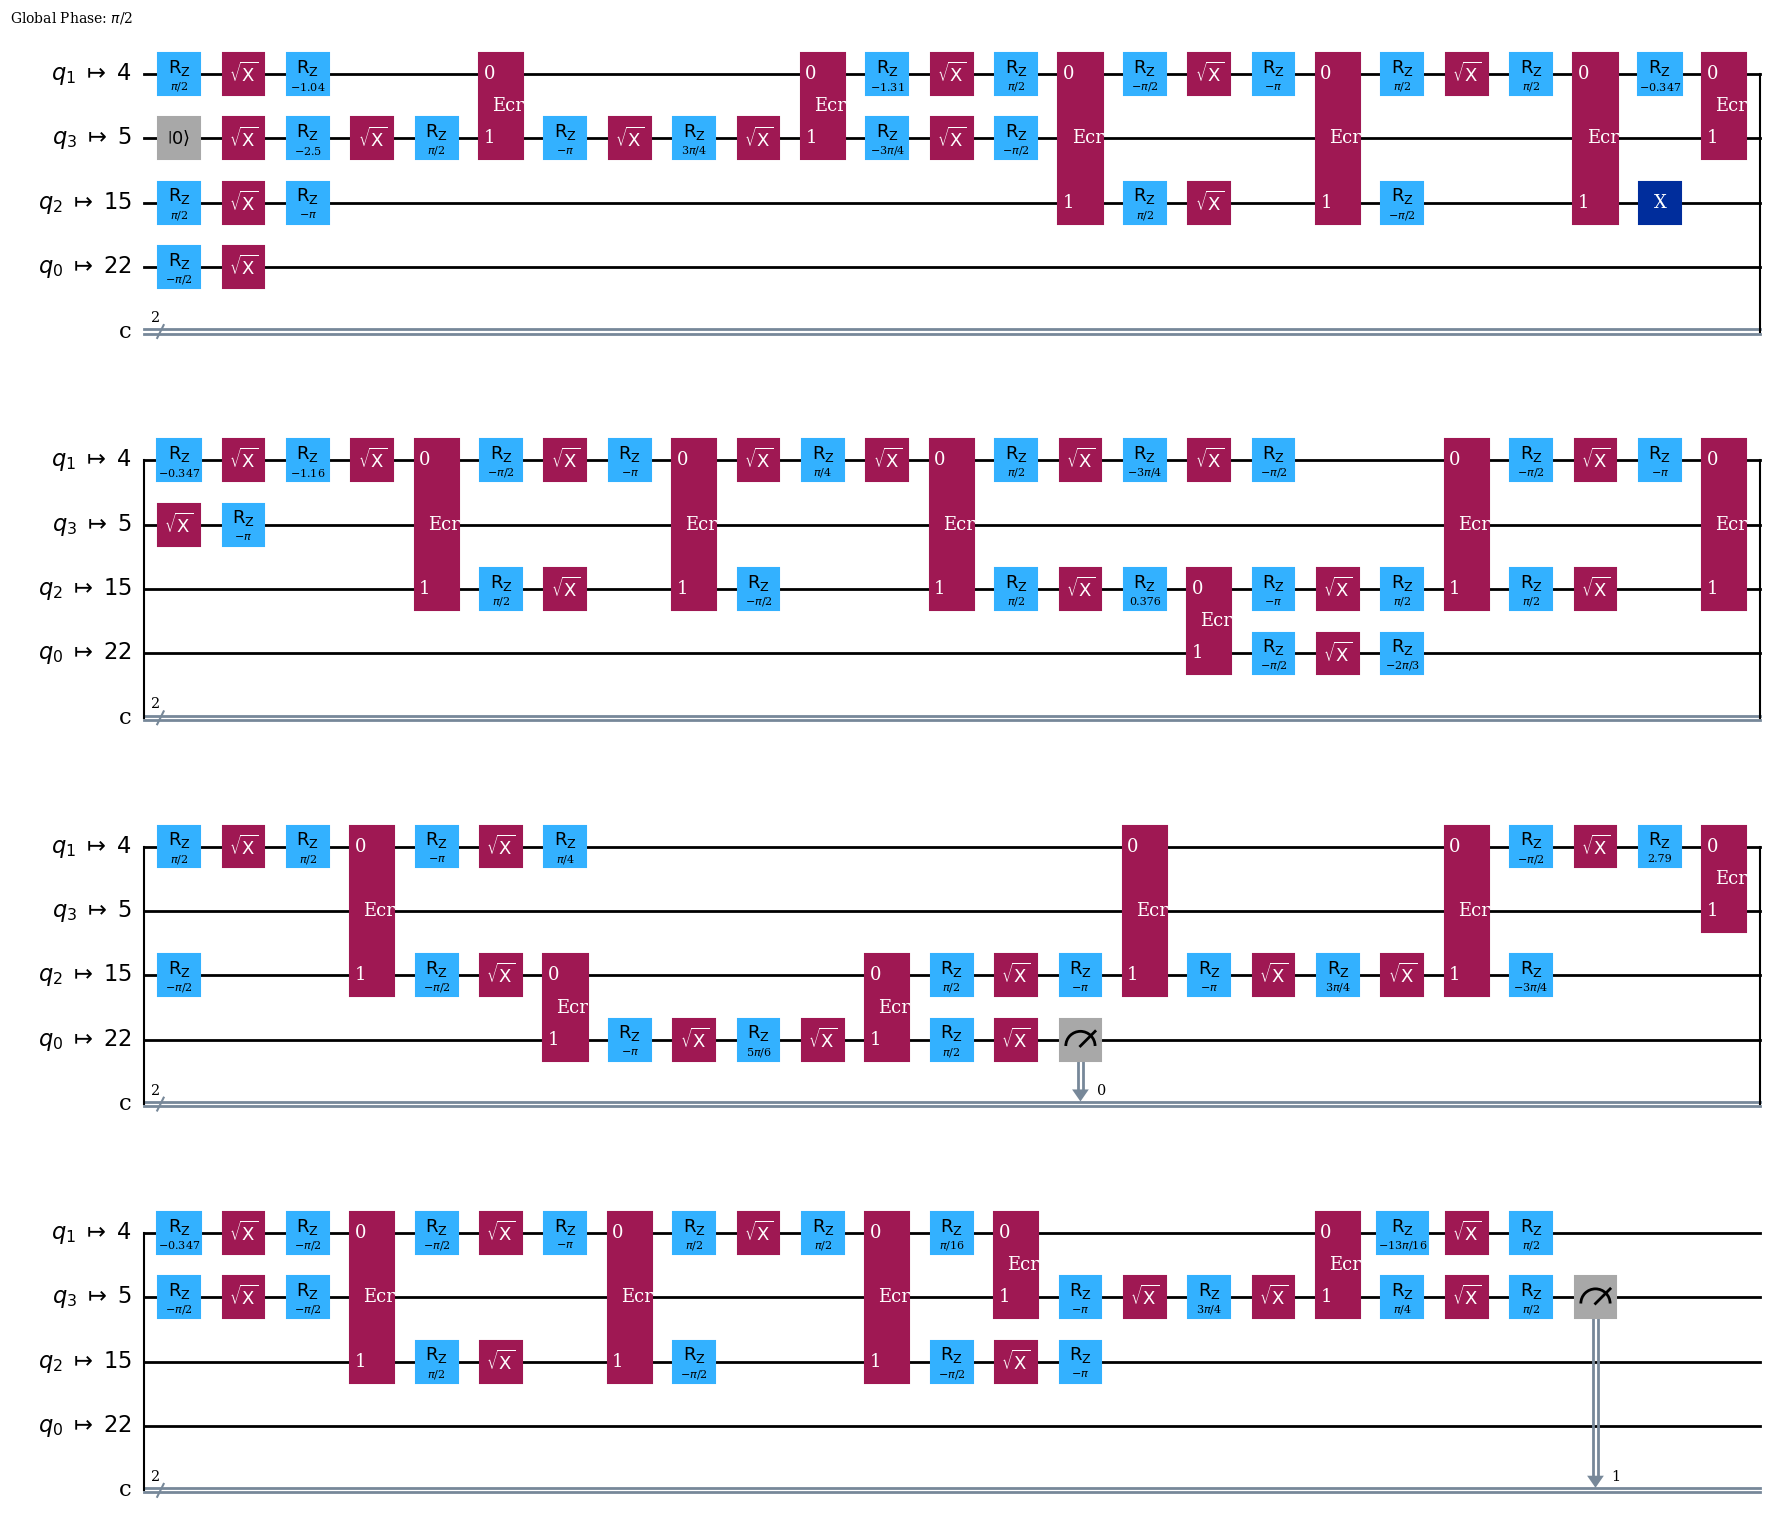

In [47]:
transpiled_qc = transpile(final_circuit_with_measurements, backend=backend, optimization_level=3)
print(f'Depth of circuit after transpiling: {transpiled_qc.depth()}')
transpiled_qc.draw(output="mpl",idle_wires=False)

The real device has more qubits than what we need. So we also have to adapt the observables to the updated circuit. The next cell shows how it can be done.

Remark that it consists of adding $I$ on all the qubit we don't use.

In [48]:
observables_layout = [ O.apply_layout(transpiled_qc.layout) for O in observables]
print("The layout of the observables is:", observables_layout[0])

The layout of the observables is: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[ 0.5+0.j, -0.5+0.j])


Now, we instantiate the [`Estimator`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) interface which allows us to use the backend for observables measurement.

In [49]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator_hardware = Estimator(mode=backend)

Finally, we can submit the circuit, which is done in the same fashion as in the tutorial. Fill in the argument with the transpiled circuits and corresponding observables.

The real circuit, unlike the perfect simulator, estimates $\langle \sigma \rangle$ through actual measurements rather than the mathematical operations. The number of shots is indirectly specified through the `precision` argument &mdash; it is of order $O(\frac{1}{\sqrt{\mathrm{n\_shots}}})$. The lower is its value, the higher is the number of shots used.  Default is usually set to $0.015625 = \frac{1}{\sqrt{4096}}$, i.e. 4096 shots ([source](https://github.com/Qiskit/qiskit-ibm-runtime/blob/639f3071833cef46443adf83eba7ea925b00257c/qiskit_ibm_runtime/options/estimator_options.py#L39)).
 

In [50]:
job = estimator_hardware.run([(transpiled_qc, observables_layout)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d0tbr894mb60008xdh90


Compare the results with the simulated data. To retrieve the job results, do like in the simulation.

In [51]:
data_estimated = job.result()
print("The estimated expectation values are: ", data_estimated[0].data.evs)
print("The simulated expectation values are: ", data_simulated[0].data.evs)

The estimated expectation values are:  [ 0.61192246 -0.09833098  0.04276934  0.03652355]
The simulated expectation values are:  [ 0.95833333 -0.21604938  0.93209877  0.05401235]


Reconstruct the matrix $\rho$ and the state $|x\rangle$. 

How close are you from the real solution? Comment your result.

In [52]:
# rho_hardware = 
# x_hardware = ...

p_hardware = data_estimated[0].data.evs[0]
coeff_i = data_estimated[0].data.evs[0] / p_hardware
coeff_x = data_estimated[0].data.evs[1] / p_hardware
coeff_y = data_estimated[0].data.evs[2] / p_hardware
coeff_z = data_estimated[0].data.evs[3] / p_hardware
rho_hardware = (coeff_i * I + coeff_x * X + coeff_y * Y + coeff_z * Z) / 2
print("The estimated density matrix is:\n", Operator(rho_hardware).data)
print("The trace is :",(Operator(rho_hardware).data.trace()))


rho00_hardware = Operator(rho_hardware).data[0][0]
rho01_hardware = Operator(rho_hardware).data[0][1]
rho11_hardware = Operator(rho_hardware).data[1][1]
rho10_hardware = Operator(rho_hardware).data[1][0]

x0_hardware = np.sqrt(rho00_hardware)
## Without loss of generality, we can take the phase of rho00 to be 0
x1_hardware = np.sqrt(rho11_hardware) * np.exp(1j * np.angle(rho10_hardware))

x_hardware = np.array([x0_hardware, x1_hardware])

print("The reconstructed solution is:", x_hardware)

print("Error between the noisy solution and the expected one", np.linalg.norm(x_hardware - expected_solution))

The estimated density matrix is:
 [[ 0.52984328+0.j        -0.08034595-0.0349467j]
 [-0.08034595+0.0349467j  0.47015672+0.j       ]]
The trace is : (1+0j)
The reconstructed solution is: [ 0.72790335+0.j         -0.62877721+0.27348846j]
Error between the noisy solution and the expected one 0.6887530039347634
